# Predicting Customer Satisfaction using Deep learning on Airline tweets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read in the data 
data = pd.read_csv("Tweets.csv")
print(data.shape)
data.head()

(14640, 15)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Before modelling can be performed, we will need to process the text in a way that best allows machine learning models to learn from the data.

Firstly, we care only about english words, and not usernames, punctuation and links in the data. As such, these words should be removed from the text.

Next, any characters in the data that are not standard english, such as emojis and other language characters, should be removed.

Finally, we turn all words to lower case for standardisation

In [3]:
import re
import string

# Define a function to apply on the tweets column
def process_text(text):
    start_list = ["@", "&", "#", "http://"]
    punct = string.punctuation
    punct_translation = str.maketrans("", "", punct)
    text = text.encode("ascii", errors = "replace").decode()

    processed = []
    # For every word in the text, split by spaces or new lines,
    for word in re.split(r"\s|\n", text):
        
        # Check if the word starts with a string from start_list
        cont = False
        for start in start_list:
            if word.startswith(start): cont = True
            if word == "": cont = True

        # If the word starts with a string from start_list, ignore the word
        if cont: continue
    
        # Remove punctuations from the word using translate
        no_punct = word.translate(punct_translation).strip()

        # If the word is a number, ignore the word
        if no_punct.isnumeric(): continue

        # Keep all other words
        processed.append(no_punct)

    # Return all words joined together, and turn it into lower case
    return " ".join(processed).lower()

data["processed"] = data["text"].apply(process_text)

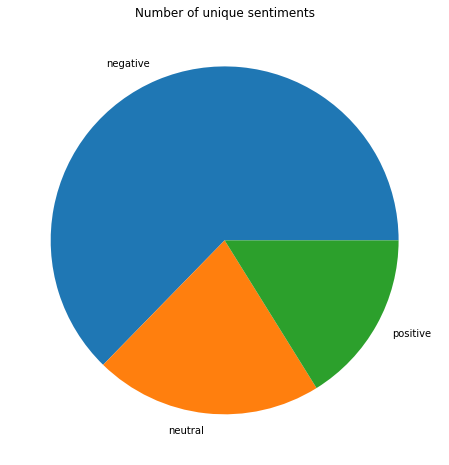

In [4]:
# Plot the number of unique sentiments in a pie chart
sentiment_counts = data["airline_sentiment"].value_counts()

plt.figure(figsize = (12, 8))
plt.title("Number of unique sentiments")
plt.pie(
    sentiment_counts,
    labels = sentiment_counts.index
)

plt.gcf().set_facecolor("white")
plt.show()

We find that there is a problem with class imbalance. Class imbalance can result in a biased model, with higher tendencies to predict the majority class rather than the minority classes. As such, we should resample the data such that the proportions of the target class are similar.

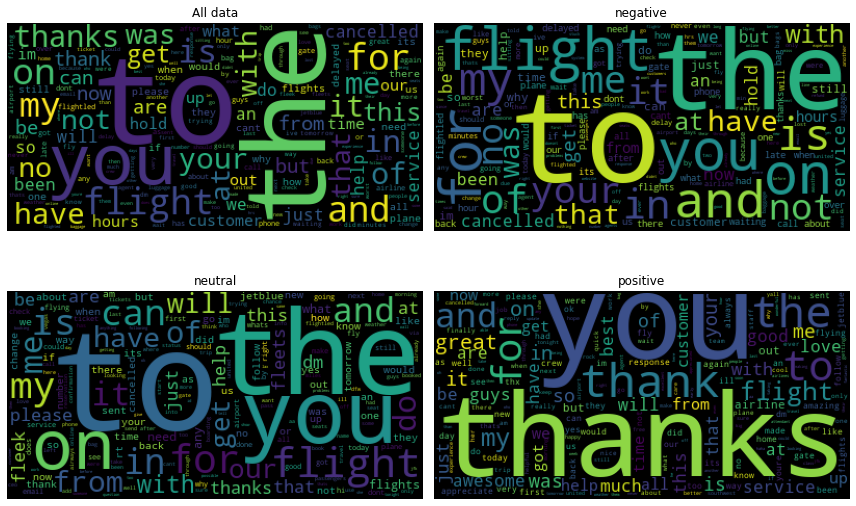

In [5]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

# Plot a word cloud to show unique words in each class of sentiments
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 8))
axs = axs.flatten()

# For each sentiment,
for i, sentiment in enumerate(sentiment_counts.index, start = 1):
    # Find all tweets belonging to the current sentiment
    subset = data.loc[data["airline_sentiment"] == sentiment, "processed"]

    # Use TFIDF vectorizer to encode the words
    vectorizer = TfidfVectorizer()
    vectorized = vectorizer.fit_transform(subset).toarray()

    # Create a wordcloud based on the frequency of the encoded tweet
    freqs = pd.Series(vectorized.T.sum(axis = 1), index = vectorizer.get_feature_names_out())
    cloud = WordCloud().generate_from_frequencies(freqs)
    axs[i].imshow(cloud)
    axs[i].set_title(sentiment)
    axs[i].axis("off")


# Finally, create one last wordcloud containing words from all tweets
vectorized = vectorizer.fit_transform(data["processed"]).toarray()
freqs = pd.Series(vectorized.T.sum(axis = 1), index = vectorizer.get_feature_names_out())
full_cloud = WordCloud().generate_from_frequencies(freqs)

axs[0].imshow(full_cloud)
axs[0].set_title("All data")
axs[0].axis("off")

plt.tight_layout()
plt.show()

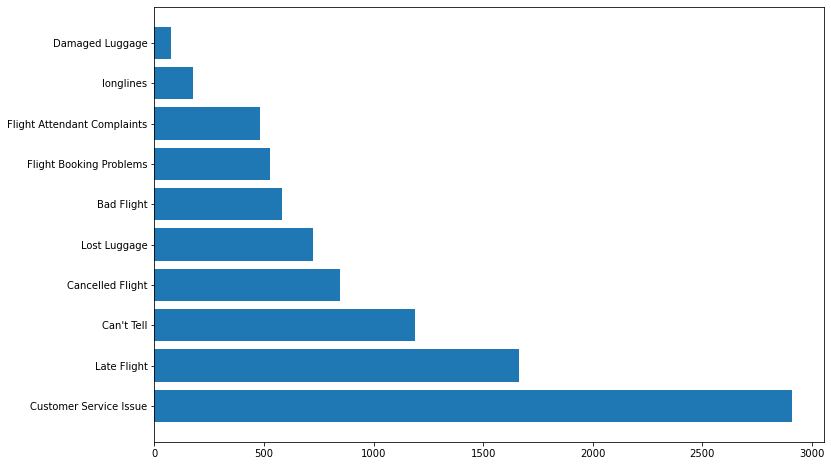

In [6]:
# Look at the possible reasons why someone would give a negative tweet
negative_reasons = data["negativereason"].value_counts()

plt.figure(figsize = (12, 8))
plt.barh(y = negative_reasons.index, width = negative_reasons.values)
plt.show()

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Check the shape of the vectorised data, too many unique words may lead to overfitting
print(vectorized.shape)

# Split the data into train, val and test sets to fit a baseline model
# Train 60%, Val 20%, Test 20%
X_train, X_val_test, y_train, y_val_test = train_test_split(
    vectorized, data["airline_sentiment"], test_size = 0.4, random_state = 242
)

X_val, X_test, y_val, y_test = train_test_split(
    X_val_test, y_val_test, test_size = 0.5, random_state = 242
)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(14640, 12114)
(8784, 12114)
(2928, 12114)
(2928, 12114)


### Train a simple baseline model

In [8]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train, y_train)

# Check the training and test accuracies
print(model.score(X_train, y_train))
print(model.score(X_val, y_val))

0.7651411657559198
0.4952185792349727


A model trained on data without further processing performs well on the training data, but not as well on the test data. We further process the data through resampling and text processing to improve the quality of the data

In [9]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

# Define a function to help evaluate models
def evaluate_model(model, X, y, nn = False, show = True):
    # Predict the labels given an input X
    y_pred = model.predict(X)

    # If the model we are evaluating is not a neural network,
    if not nn:
        # Get the probabilities of each class using predict_proba
        y_prob = model.predict_proba(X)
        true = y

    # If the model is a neural network
    else:
        # The probabilies are the values from model.predict()
        y_prob = y_pred

        # The predicted labels are found by taking the maximum probability
        y_pred = np.argmax(y_pred, axis = 1)
        # The true labels are found by taking the maximum probability in the given y input
        true = np.argmax(y, axis = 1)


    # Calculate metrics to quantify model performance
    acc = accuracy_score(true, y_pred)
    f1  = f1_score(true, y_pred, average = "macro")
    roc = roc_auc_score(y, y_prob, multi_class = "ovr")

    # Create a confusion matrix
    cnfm = confusion_matrix(true, y_pred)

    # If we want to show the results,
    if show:
        print(f"Accuracy Score: {acc:.3f}")
        print(f"F1 Score:       {f1:.3f}")
        print(f"ROC AUC Score:  {roc:.3f}")

        plt.figure(figsize = (12, 8))
        plt.title("Confusion Matrix")
        sns.heatmap(cnfm, cmap = "Blues", annot = True, fmt = ".0f")
        plt.ylabel("True")
        plt.xlabel("Predicted")
        plt.show()

    return acc, f1, roc, cnfm

### Mitigate class imbalance using Synthetic Minority Oversampling Technique (SMOTE)

To address the class imbalance issue, we can upsample the minority class to balance out the class proportions. However, if we were the duplicate the minority class data to upsample the data, we run the risk of overfitting as the model would have seen the same data points multiple times.

SMOTE creates synthetic data points based on the minority classes that are different enough from the original data so as to mitigate the overfitting issue.


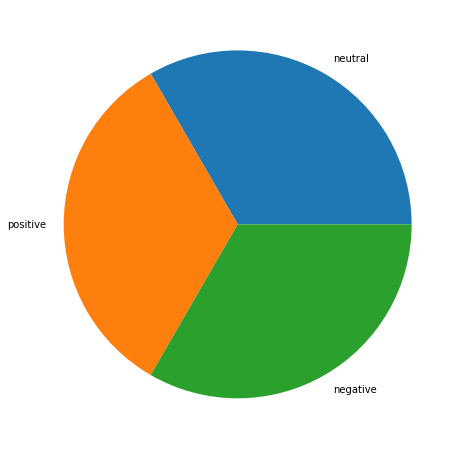

In [10]:
from imblearn.over_sampling import SMOTE

# Create the smote oversampler from imblearn
smote = SMOTE(random_state = 242)
X_samp, y_samp = smote.fit_resample(X_train, y_train)

# Plot the resampled counts to observe the problem of class imbalance
sampled_counts = y_samp.value_counts()

plt.figure(figsize = (12, 8))
plt.pie(sampled_counts, labels = sampled_counts.index)
plt.gcf().set_facecolor("white")
plt.show()

### Improve the detail of cleaning

Cleaning can be improve by removing stopwords and using parts of speech (POS) tagging to further reduce noise.

Parts of speech tagging assigns a part of speech (nouns, conjunctions, verbs, etc) to every word in a sentence. Based on these tags, we can remove words that are not nouns and adjectives, as nouns (desk, table) and adjectives (big, small) would provide the most context regarding the sentiment of the tweet.

Additionally, we remove words that contain no valuable information such as "the", "this", "I" etc. These are known as stop words.

In [11]:
import nltk
from nltk.corpus import stopwords
from nltk import pos_tag

# Get a list of stopwords from nltk package
nltk.download("stopwords")
stop_words = stopwords.words("english")

# Build upon process text for a more extensive cleaning process to reduce noise
def process_text(text):
    start_list = ["@", "&", "#", "http://"]
    punct = string.punctuation
    punct_translation = str.maketrans("", "", punct)
    text = text.encode("ascii", errors = "replace").decode()

    processed = []
    for word in re.split(r"\s|\n", text):

        cont = False
        for start in start_list:
            if word.startswith(start): cont = True
            if word == "": cont = True

        if cont: continue
        # If the word is in the stopwords list, ignore the word
        if word in stop_words: continue

        no_punct = word.translate(punct_translation).strip()
        if no_punct.isnumeric(): continue

        processed.append(no_punct)

    # Check the pos tag of the current word, only keep words with the tags of interest
    final = []
    for word, tag in pos_tag(processed):
        # If the word is not a pos we want, ignore the word
        if tag not in ["JJ", "JJR", "JJS", "NN", "NNS", "NNP", "NNPS"]:
            continue

        final.append(word)

    # Finally, join the words together in a string, and turn it into lower case
    return " ".join(final).lower()


data["processed_2"] = data["text"].apply(process_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/niromikha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The text data is vectorised using TFIDF vectorisation, which is a vectorisation technique that assigns a score to each word in the text. Words that appear too freqeuntly or infrequently are given a lower score than words that appear just often enough. This is because we believe the most important words in a text are those that are commonly understood. Words that appear too often would be words like "flight", "airport", which do not give much information about the sentiment. Words that are too infrequently are typos, slangs and complex words, which do not give much information regarding the sentiment as well.

In [12]:
# Repeat the vectorisation process, and resample using SMOTE on the newly cleaned data
vectorizer = TfidfVectorizer()
vectorized_2 = vectorizer.fit_transform(data["processed_2"]).toarray()

print(vectorized_2.shape)

# Train with 70% training, 20% val, 10% test (Push more data to training set)
X_train, X_val_test, y_train, y_val_test = train_test_split(
    vectorized_2, data["airline_sentiment"], test_size = 0.3, random_state = 242,
    stratify = data["airline_sentiment"], shuffle = True
)

X_val, X_test, y_val, y_test = train_test_split(
    X_val_test, y_val_test, test_size = 1/3, random_state = 242,
    stratify = y_val_test, shuffle = True
)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

smote = SMOTE(random_state = 242)
X_train, y_train = smote.fit_resample(X_train, y_train)
train_idx = np.arange(len(X_train))
np.random.shuffle(train_idx)

X_train = X_train[train_idx]
y_train = y_train[train_idx]

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(14640, 9447)
(19275, 9447)
(2928, 9447)
(1464, 9447)


### Develop an feed forward neural network and a LSTM network

In [13]:
import keras 
from keras import layers
from sklearn.preprocessing import LabelEncoder

# Define a function to prepare the data in a format needed to train neural networks
def prepare_nn_data(y_train, y_val, y_test):
    encoder = LabelEncoder()
    
    # One hot encode the target values into their respective classes
    train_target = pd.get_dummies(encoder.fit_transform(y_train)).values
    val_target = pd.get_dummies(encoder.fit_transform(y_val)).values
    test_target = pd.get_dummies(encoder.fit_transform(y_test)).values

    return train_target, val_target, test_target, encoder


# Define a function to generate a feed forward netword
def FFN(input_size):
    # The model will have 3 fully connected layers with 512 nodes, and a output layer with 3 nodes
    # Optimizer: adam, loss function: Categorical Cross Entropy, Metrics: ROC AUC
    
    model = keras.Sequential()
    model.add(layers.Dense(input_size, input_shape = (input_size, )))
    model.add(layers.Dense(512))
    model.add(layers.Dense(512))
    model.add(layers.Dense(512))
    model.add(layers.Dense(3, activation = "sigmoid"))

    model.compile(
        optimizer = "adam",
        loss = keras.losses.CategoricalCrossentropy(),
        metrics = [keras.metrics.AUC()]
    )

    return model

In [14]:
from keras.preprocessing.text import one_hot
from keras.utils import pad_sequences


# Define a function to generate a LSTM network
def LSTM(input_size):
    # The model will only be made up of 1 bidirectional LSTM layer with 100 nodes, followed by a 
    # dropout layer to handle overfitting. The output layers consist of 3 nodes
    # Optimizer: adam, loss function: Categorical Cross Entropy, Metrics: ROC AUC

    model = keras.Sequential()
    model.add(layers.Bidirectional(
        layers.LSTM(100, return_sequences = False),
        input_shape = (1, input_size)
    ))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(3, activation = "sigmoid"))

    model.compile(
        optimizer = "adam",
        loss = keras.losses.CategoricalCrossentropy(),
        metrics = [keras.metrics.AUC()]
    )

    return model

The data is passed through 2 models, FFN and LSTM to evalaute which model performs the best

In [15]:
# Create the 2 networks for training

vocab_size = X_train.shape[1]
ffn = FFN(vocab_size)
lstm = LSTM(vocab_size)

# Encode the target for neural network training, using prepare_nn_data
y_train_nn, y_val_nn, y_test_nn, encoder = prepare_nn_data(y_train, y_val, y_test)
classes = encoder.classes_

# LSTM requires the input to be in 3 dimension (# data points, # per batch, # features)
lstm_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
lstm_val = X_val.reshape(X_val.shape[0], 1, X_train.shape[1])
lstm_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Train the 2 networks
ffn_history = ffn.fit(X_train, y_train_nn)
lstm_history = lstm.fit(lstm_train, y_train_nn)

603/603 [==============================] - 21s 30ms/step - loss: 0.6354 - auc_1: 0.8756


603/603 [==============================] - 30s 50ms/step
Accuracy Score: 0.676
F1 Score:       0.650
ROC AUC Score:  0.619


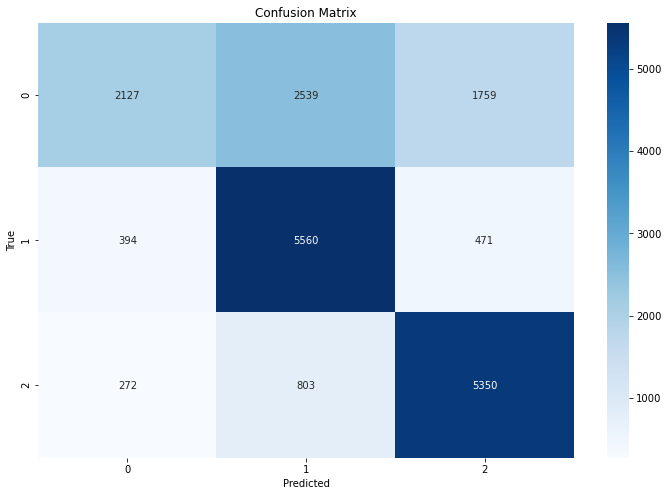

603/603 [==============================] - 4s 6ms/step
Accuracy Score: 0.891
F1 Score:       0.891
ROC AUC Score:  0.974


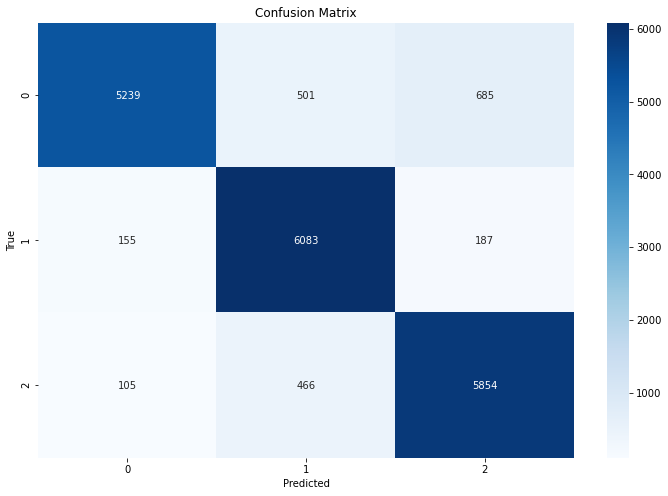

In [16]:
# Show the scores of each model on the training set
ffn_train_scores = evaluate_model(ffn, X_train, y_train_nn, nn = True)
lstm_train_scores = evaluate_model(lstm, lstm_train, y_train_nn, nn = True)

92/92 [==============================] - 5s 50ms/step
Accuracy Score: 0.396
F1 Score:       0.396
ROC AUC Score:  0.531


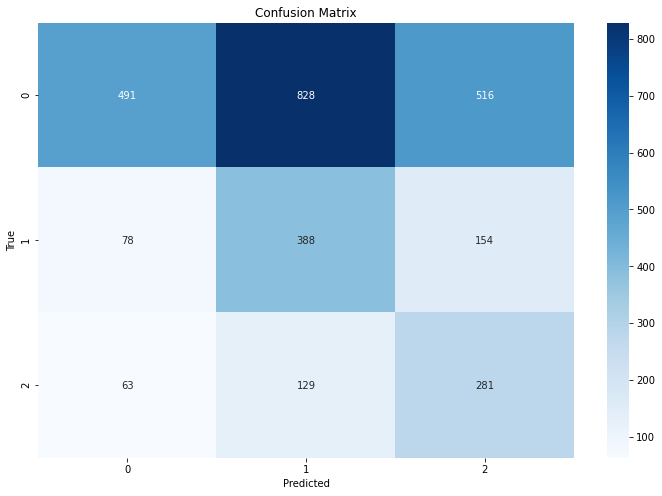

92/92 [==============================] - 1s 6ms/step
Accuracy Score: 0.643
F1 Score:       0.574
ROC AUC Score:  0.763


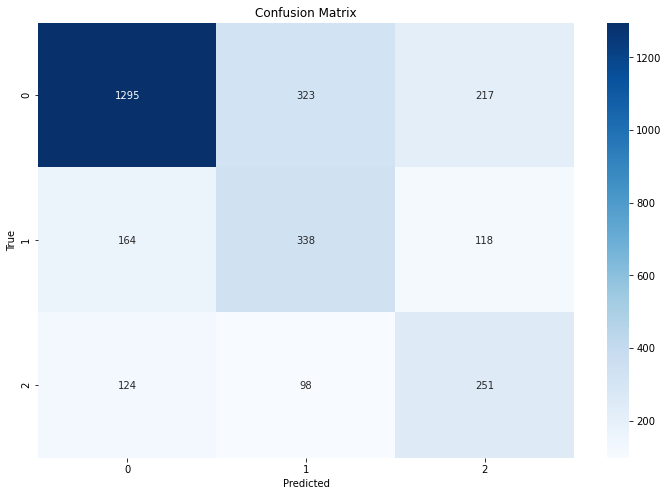

In [17]:
# Show the scores of each model on the validation set
ffn_val_scores = evaluate_model(ffn, X_val, y_val_nn, nn = True)
lstm_val_scores = evaluate_model(lstm, lstm_val , y_val_nn, nn = True)

### Hyperparameter Tuning

In [18]:
def LSTM(input_size, num_layers = 1, num_nodes = 100):
    # Define a function that creates an LSTM network with the given parameters

    model = keras.Sequential()

    for i in range(num_layers):
        model.add(layers.Bidirectional(
            layers.LSTM(num_nodes, return_sequences = i != (num_layers - 1)),
            input_shape = (1, input_size)
        ))
        model.add(layers.Dropout(0.2))
    
    model.add(layers.Dense(3, activation = "sigmoid"))

    model.compile(
        optimizer = "adam",
        loss = keras.losses.CategoricalCrossentropy(),
        metrics = [keras.metrics.AUC()]
    )

    return model

In [19]:
import itertools

vocab_size = lstm_train.shape[2]
lstm_grid = {
    "num_layers": [1, 2, 3],
    "num_nodes": [10, 25, 50, 100]
}

# Takes ~20minutes to run
validation_results = []
all_combinations = itertools.product(*lstm_grid.values())
for i, combination in enumerate(all_combinations):
    print(f"{i}/12", end = "\r")

    # For each combination of parameters, fit the model and evaluate on validation set
    num_layers, num_nodes = combination
    model = LSTM(vocab_size, num_layers, num_nodes)
    model.fit(lstm_train, y_train_nn)

    split_results = {}
    acc, f1, roc, cnfm = evaluate_model(model, lstm_val, y_val_nn, nn = True, show = False)

    # Score the model and store it for comparison
    split_results["Params"] = combination
    split_results["Accuracy"] = acc
    split_results["F1"] = f1
    split_results["ROC AUC"] = roc
    split_results["Confusion Matrix"] = cnfm

    validation_results.append(split_results)

92/92 [==============================] - 3s 9ms/step


In [20]:
# Find the best parameter using ROC as a metric
results_df = pd.DataFrame(validation_results)
display(results_df)
best_params = results_df.sort_values(by = "ROC AUC", ascending = False).iloc[0, 0]
best_params

,Params,Accuracy,F1,ROC AUC,Confusion Matrix
0,"(1, 10)",0.673156,0.580373,0.761146,"[[1462, 232, 141], [252, 265, 103], [148, 81, ..."
1,"(1, 25)",0.679645,0.599061,0.773285,"[[1429, 263, 143], [217, 314, 89], [137, 89, 2..."
2,"(1, 50)",0.654030,0.581404,0.753775,"[[1336, 315, 184], [184, 331, 105], [130, 95, ..."
3,"(1, 100)",0.657787,0.584601,0.764936,"[[1350, 316, 169], [191, 315, 114], [113, 99, ..."
4,"(2, 10)",0.681694,0.593599,0.771935,"[[1468, 232, 135], [251, 273, 96], [142, 76, 2..."
5,"(2, 25)",0.688525,0.595196,0.784035,"[[1489, 194, 152], [230, 270, 120], [145, 71, ..."
6,"(2, 50)",0.677254,0.586629,0.762340,"[[1453, 218, 164], [216, 271, 133], [145, 69, ..."
7,"(2, 100)",0.683060,0.598359,0.772656,"[[1455, 251, 129], [232, 305, 83], [145, 88, 2..."
8,"(3, 10)",0.657445,0.568887,0.773269,"[[1399, 222, 214], [225, 233, 162], [128, 52, ..."
9,"(3, 25)",0.669057,0.589567,0.780845,"[[1405, 265, 165], [230, 288, 102], [120, 87, ..."


(2, 25)

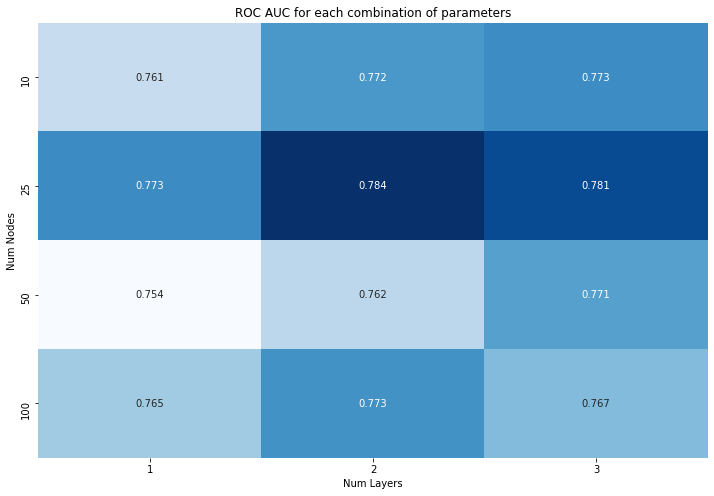

In [21]:
num_nodes = lstm_grid["num_nodes"]
num_layers = lstm_grid["num_layers"]

params_roc = np.zeros(shape = (4, 3))

for i, node in enumerate(num_nodes):
    for j, layer in enumerate(num_layers):
        params_roc[i, j] = results_df.loc[
            results_df["Params"] == (layer, node),
            "ROC AUC"
        ].iloc[0]


plt.figure(figsize = (12, 8))
plt.title("ROC AUC for each combination of parameters")
sns.heatmap(
    params_roc,
    cmap = "Blues", cbar = False,
    annot = True, fmt = ".3f",
    yticklabels = num_nodes,
    xticklabels = num_layers
)
plt.ylabel("Num Nodes")
plt.xlabel("Num Layers")
plt.show()

In [22]:
num_layers, num_nodes = best_params
best_model = LSTM(vocab_size, num_layers, num_nodes)
history = best_model.fit(
    lstm_train, y_train_nn, epochs = 1, validation_data = (lstm_val, y_val_nn)
)

603/603 [==============================] - 14s 14ms/step - loss: 0.6605 - auc_14: 0.8802 - val_loss: 0.8900 - val_auc_14: 0.8139


46/46 [==============================] - 2s 4ms/step
Accuracy Score: 0.673
F1 Score:       0.591
ROC AUC Score:  0.769


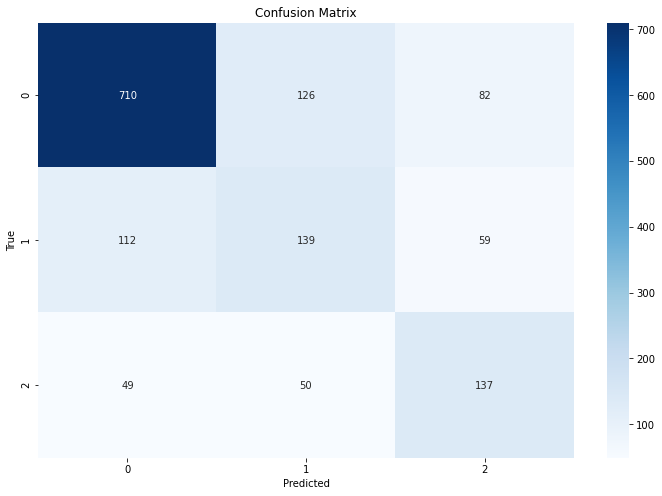

(0.6734972677595629,
 0.590537816415202,
 0.7691499918258807,
 array([[710, 126,  82],
        [112, 139,  59],
        [ 49,  50, 137]]))

In [23]:
evaluate_model(best_model, lstm_test, y_test_nn, nn = True, show = True)

92/92 [==============================] - 0s 4ms/step
Accuracy Score: 0.680
F1 Score:       0.595
ROC AUC Score:  0.763


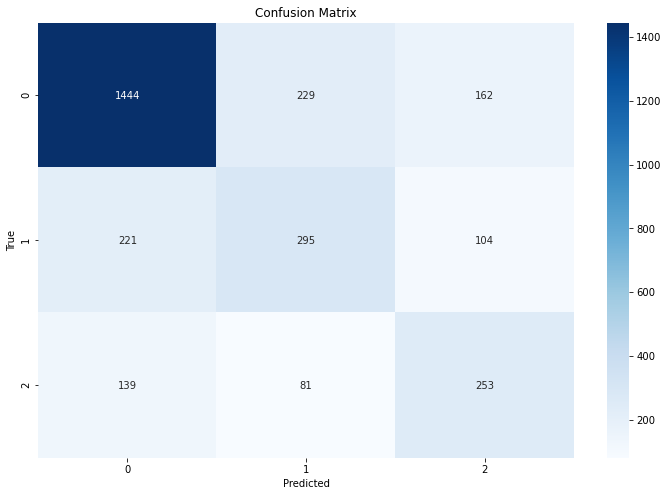

(0.680327868852459,
 0.595112640123819,
 0.7628665381823198,
 array([[1444,  229,  162],
        [ 221,  295,  104],
        [ 139,   81,  253]]))

In [24]:
evaluate_model(best_model, lstm_val, y_val_nn, nn = True, show = True)

### Test the model on a new sentiment not seen in the data

In [25]:
# Define a function to predict new tweets using the trained model
def predict_new_tweet(tweet):
    # Process the tweet in the same way as during preprocessing
    processed = process_text(tweet)

    # Transform the tweet using the same vectoriser as before
    vectorised_tweet = vectorizer.transform([processed]).toarray()
    vectorised_tweet = scaler.transform(vectorised_tweet)

    # Reshape the array for neural network prediction
    vectorised_tweet_nn = vectorised_tweet.reshape(
        vectorised_tweet.shape[0], 1, vectorised_tweet.shape[1]
    )

    # Get the predicted scores
    label_prob = best_model.predict(vectorised_tweet_nn, verbose = 0)
    label = np.argmax(label_prob, axis = 1)

    # Return the label of the prediction
    return encoder.inverse_transform(label)[0]

tweet_1 = predict_new_tweet("Virgin airlines has great customer support")
tweet_2 = predict_new_tweet("The service in Singapore airines was extremely dissapointing")
tweet_3 = predict_new_tweet("The food in Qatar Airways was okay")

print("\nTests on new sentiments not in data (unseen data)")
print("----------------------------------------")
print("Tweet 1: Virgin airlines has great customer support \n Predicted Sentiment:", tweet_1)
print("\nTweet 2: The service in Singapore airines was extremely dissapointing \n Predicted Sentiment:", tweet_2)
print("\nTweet 3: The food in Qatar Airways was okay \n Predicted Sentiment:", tweet_3)


Tests on new sentiments not in data (unseen data)
----------------------------------------
Tweet 1: Virgin airlines has great customer support 
 Predicted Sentiment: positive

Tweet 2: The service in Singapore airines was extremely dissapointing 
 Predicted Sentiment: negative

Tweet 3: The food in Qatar Airways was okay 
 Predicted Sentiment: neutral


In [26]:
input_area = (input(f"Put your tweet to test! "))
answer = predict_new_tweet(input_area)
print("Prediction of sentiment on your Tweet: ", answer)

Put your tweet to test! Ryan air has the best service!
Prediction of sentiment on your Tweet:  positive


# References

[1] Suvrat Arora. 2022. Sentiment Analysis Using Python. Analytics Vidhya. Retrieved September 18, 2023 from https://www.analyticsvidhya.com/blog/2022/07/sentiment-analysis-using-python/
[2] Paritosh Mahto. 2020. PANDAS For Machine Learning - MLpoint - Medium. Medium. Retrieved September 18, 2023 from https://medium.com/mlpoint/pandas-for-machine-learning-53846bc9a98b#:~:text=Pandas%20is%20one%20of%20the%20tools%20in%20Machine%20Learning%20which,transforming%20and%20visualizing%20from%20data.
[3] Joos Korstanje. 2021. SMOTE | Towards Data Science. Medium. Retrieved September 18, 2023 from https://towardsdatascience.com/smote-fdce2f605729
[4] Jason Brownlee. 2017. How to Tune LSTM Hyperparameters with Keras for Time Series Forecasting - MachineLearningMastery.com. MachineLearningMastery.com. Retrieved September 18, 2023 from https://machinelearningmastery.com/tune-lstm-hyperparameters-keras-time-series-forecasting/